<a href="https://colab.research.google.com/github/chavamoon/Fintech_Ejemplos/blob/main/fintech_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Return Prediction

En este Notebook veremos varios algoritmos de Aprendizaje Supervisado para predecir el precio de las acciones de Microsost usando assets correlacionados y datos historicos.

Utilizaremos datos historicos de Microsoft, y variables independientes que pueden ser assests correlacionados:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

Trataremos de predecir los retornos semanales: Mas o menos equivalen a 5 dias de la semana.

# Librerias

In [1]:
!pip install pandas-datareader --upgrade
!pip install yfinance

     |████████████████████████████████| 109 kB 9.8 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 37.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you ha

In [3]:
#Librerias
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime    

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Modelos de Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Librerias Estadisticas
import statsmodels.api as sm

#Salvar y guardar Modelos
from pickle import dump
from pickle import load

# Modelos de Series de Tiempo
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metricas de Error
from sklearn.metrics import mean_squared_error

# Seleccion de Variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Graficar 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Eliminar Warnings

In [4]:
import warnings
warnings.filterwarnings('ignore')

# ETL

In [5]:
import yfinance as yf

In [6]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
start_date = "2010-01-01"
stocks_df = []
for s in stk_tickers:
    stk_data = yf.Ticker(s)
    stk_data = stk_data.history(start=start_date)
    stk_data.columns = pd.MultiIndex.from_tuples([(c,s) for c in stk_data.columns])
    stocks_df.append(stk_data)
stk_data = pd.concat(stocks_df ,axis=1)

ccy_data = web.DataReader(ccy_tickers, 'fred', start=start_date)
idx_data = web.DataReader(idx_tickers, 'fred', start=start_date)

In [7]:
#Establece cuanto nos moveremos hacia adelante
return_period = 1

Separamos el target y las features.
Creamos la serie de tiempo.

Todas las variables exceptuando MSFT estan laggeadas.  
Ademas tenemos lags de MSFT para 5, 15, 30, y 60 dias.

In [8]:
stk_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open,High,Low,...,Volume,Dividends,Stock Splits,Open,High,Low,Close,Volume,Dividends,Stock Splits
,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT,IBM,IBM,IBM,...,IBM,IBM,IBM,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,23.601304,23.971278,23.578180,23.855661,38409100,0.0,0,82.063984,83.183778,81.857545,...,6438444,0.0,0.0,313.788788,315.070068,312.432434,313.688690,3908488,0,0.0
2010-01-05,23.778577,23.971272,23.616712,23.863361,49749600,0.0,0,82.376729,82.483082,81.388311,...,7156104,0.0,0.0,313.903900,314.234222,311.081085,312.307312,6003391,0,0.0
2010-01-06,23.801710,23.955866,23.524229,23.716925,58182400,0.0,0,81.751178,82.257903,81.206924,...,5863144,0.0,0.0,313.243256,313.243256,303.483490,304.434448,7949443,0,0.0
2010-01-07,23.609008,23.662963,23.269865,23.470268,50559700,0.0,0,81.244457,81.482179,80.643900,...,6109268,0.0,0.0,305.005005,305.305298,296.621613,297.347351,12815771,0,0.0
2010-01-08,23.339236,23.801703,23.308404,23.632132,51197400,0.0,0,80.743961,81.901286,80.731450,...,4390271,0.0,0.0,296.296295,301.926941,294.849854,301.311310,9439151,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,305.230011,305.500000,299.290009,303.679993,22550600,0.0,0,129.500000,131.399994,129.309998,...,3530200,0.0,0.0,2838.320068,2840.699951,2794.750000,2833.459961,1206300,0,0.0
2022-03-28,304.329987,310.799988,304.329987,310.700012,29578200,0.0,0,130.820007,131.500000,129.600006,...,2483500,0.0,0.0,2818.010010,2840.050049,2796.229980,2829.110107,1752500,0,0.0


In [9]:
stk_data.loc[:, ('Close', 'MSFT')]

Date
2010-01-04     23.855661
2010-01-05     23.863361
2010-01-06     23.716925
2010-01-07     23.470268
2010-01-08     23.632132
                 ...    
2022-03-25    303.679993
2022-03-28    310.700012
2022-03-29    315.410004
2022-03-30    313.859985
2022-03-31    311.054993
Name: (Close, MSFT), Length: 3083, dtype: float64

In [11]:
#Regresa la diferencia entre el valro actual y uno anterior, para ver cuando se incrementó o decreció el valor de la bolsa
(stk_data.loc[:, ('Close', 'MSFT')]).diff(return_period)

Date
2010-01-04         NaN
2010-01-05    0.007700
2010-01-06   -0.146437
2010-01-07   -0.246656
2010-01-08    0.161863
                ...   
2022-03-25   -0.420013
2022-03-28    7.020020
2022-03-29    4.709991
2022-03-30   -1.550018
2022-03-31   -2.804993
Name: (Close, MSFT), Length: 3083, dtype: float64

In [13]:
# se recorren un row hacia arriba, con el fin de que cada día tenga cuando va a variar la bolsa el día siguiente, variable a predecir (Y)
stk_data.loc[:, ('Close', 'MSFT')].diff(return_period).shift(-return_period)

Date
2010-01-04    0.007700
2010-01-05   -0.146437
2010-01-06   -0.246656
2010-01-07    0.161863
2010-01-08   -0.300606
                ...   
2022-03-25    7.020020
2022-03-28    4.709991
2022-03-29   -1.550018
2022-03-30   -2.804993
2022-03-31         NaN
Name: (Close, MSFT), Length: 3083, dtype: float64

In [26]:
#Se aplican normalizaciones por logarimos para hacer los cambios más pequeños

# Lo que queremos predecir, lo de microsoft del día siguiente
Y = np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

# Transformaciones logaritmicas

#Variables X, cuanto cerró la bolsa en google, ibm, currency e índices bursátiles
X1 = np.log(stk_data.loc[:, ('Close', ('GOOGL', 'IBM'))]).diff(return_period).shift(0)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period).shift(0)
X3 = np.log(idx_data).diff(return_period).shift(0)

#variables x, cuandto vario la de microsoft en un día, en tres días, en seis días y en doce días
X4 = pd.concat([np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(i).shift(0) for i in [return_period,
                                        return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [27]:
dataset.shape

(2367, 12)

# EDA

In [28]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,2.367e+03,2.367e+03,2.367e+03,2.367e+03,2.367e+03,2.367e+03,2.367e+03,2367.000,2.367e+03,2367.000,2367.000,2367.000
mean,1.001e-03,7.723e-04,2.024e-05,1.646e-04,-3.835e-05,5.068e-04,4.567e-04,-0.001,9.919e-04,0.003,0.006,0.012
std,1.633e-02,1.607e-02,1.476e-02,5.346e-03,5.467e-03,1.057e-02,1.073e-02,0.080,1.633e-02,0.025,0.035,0.045
min,-1.595e-01,-1.237e-01,-1.375e-01,-3.498e-02,-8.169e-02,-1.277e-01,-1.384e-01,-0.300,-1.595e-01,-0.144,-0.204,-0.216
25%,-6.330e-03,-6.319e-03,-6.184e-03,-2.452e-03,-2.987e-03,-3.302e-03,-3.375e-03,-0.046,-6.448e-03,-0.010,-0.012,-0.011
50%,7.245e-04,7.840e-04,2.620e-04,1.951e-04,0.000e+00,7.024e-04,7.188e-04,-0.007,7.321e-04,0.004,0.007,0.013
75%,9.087e-03,8.798e-03,6.970e-03,2.923e-03,3.003e-03,5.255e-03,5.320e-03,0.035,9.092e-03,0.017,0.026,0.038
max,1.329e-01,1.506e-01,1.071e-01,3.343e-02,3.155e-02,8.968e-02,1.076e-01,0.768,1.329e-01,0.139,0.154,0.194


In [29]:
dataset.head(10)

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2012-04-03,-0.023,-0.007,1.434e-04,2.434e-04,-3.501e-03,-3.997e-03,-0.005,0.001,-0.011,-0.006,-0.020,-0.020
2012-04-04,0.010,-0.012,-1.661e-02,5.340e-03,-5.464e-03,-1.025e-02,-0.009,0.049,-0.023,-0.033,-0.041,-0.031
2012-04-05,-0.013,-0.004,-2.819e-03,-3.516e-03,-3.596e-03,-6.292e-04,-0.001,0.016,0.010,-0.024,-0.021,-0.015
2012-04-10,-0.004,-0.006,-1.282e-02,-5.176e-03,-2.712e-03,-1.723e-02,-0.017,0.081,-0.020,-0.024,-0.057,-0.049
2012-04-11,0.021,0.014,1.235e-03,-7.416e-04,3.530e-03,7.421e-03,0.007,-0.018,-0.004,-0.038,-0.062,-0.053
2012-04-12,-0.006,0.023,1.343e-02,-1.236e-04,2.953e-03,1.369e-02,0.014,-0.152,0.021,-0.004,-0.031,-0.051
2012-04-13,0.009,-0.041,-1.235e-02,1.483e-03,-5.536e-03,-1.255e-02,-0.011,0.128,-0.006,0.011,-0.013,-0.054
2012-04-16,0.012,-0.030,-3.941e-04,-6.566e-03,8.828e-04,-5.037e-04,0.006,0.000,0.009,0.024,-0.014,-0.035
2012-04-17,-0.010,0.006,2.306e-02,3.226e-03,4.151e-03,1.537e-02,0.015,-0.057,0.012,0.015,0.011,-0.021
2012-04-18,-0.004,-0.003,-3.592e-02,7.037e-03,5.571e-03,-4.064e-03,-0.006,0.010,-0.010,0.011,0.022,-0.035


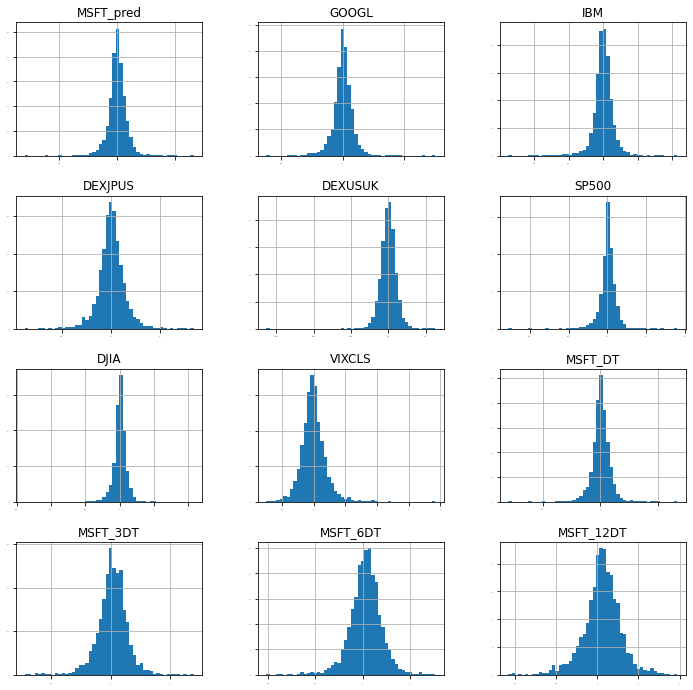

In [25]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

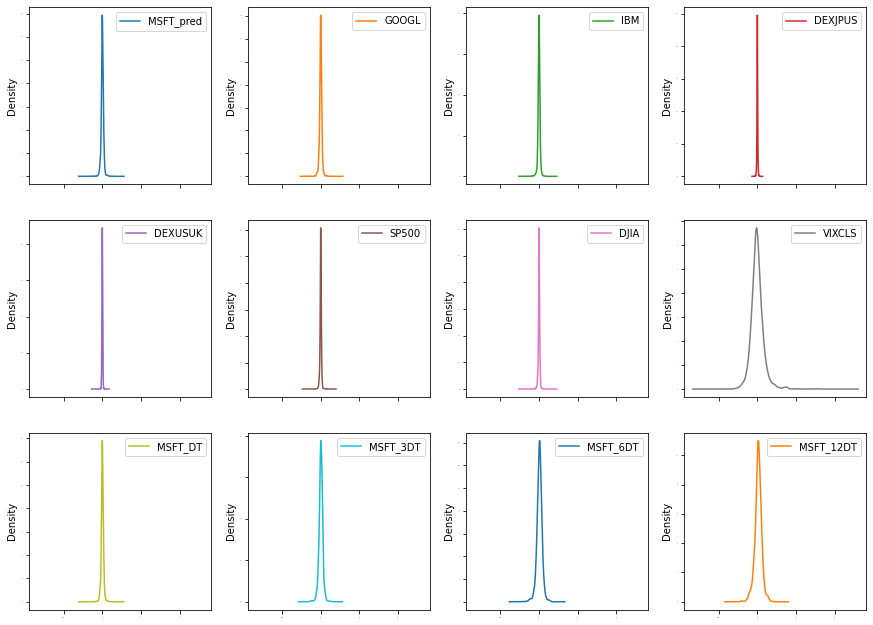

In [30]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

VIX parece tener mayor varianza comaprada a las otras distribuciones.

## Correlaciones

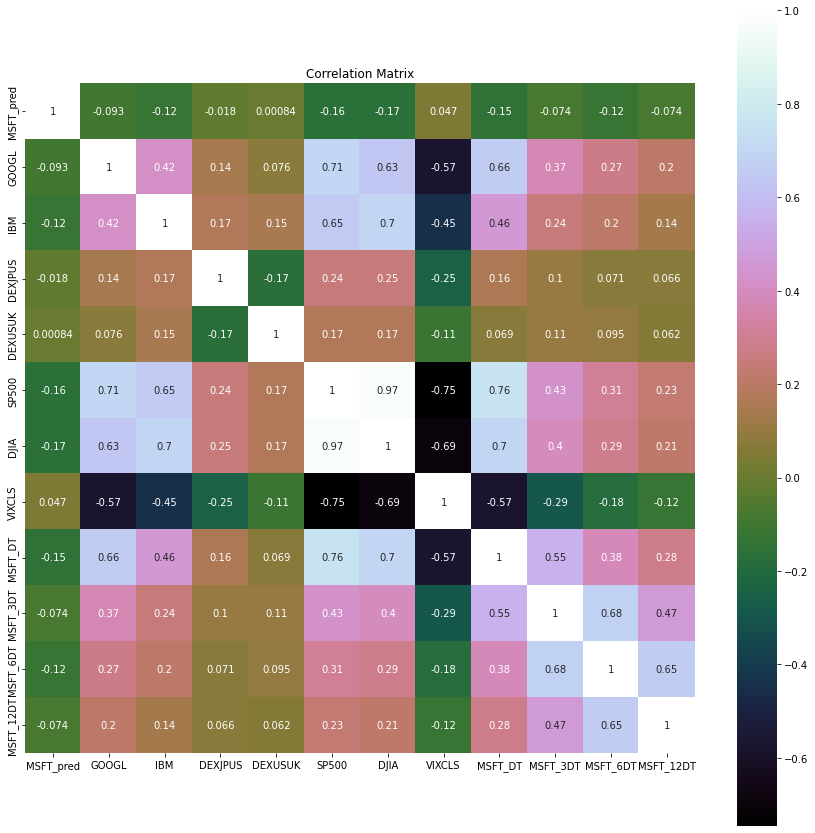

In [31]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Vemos que las correlaciones mas altas son respecto a sus variables laggeadas.

# EDA Series de Tiempo

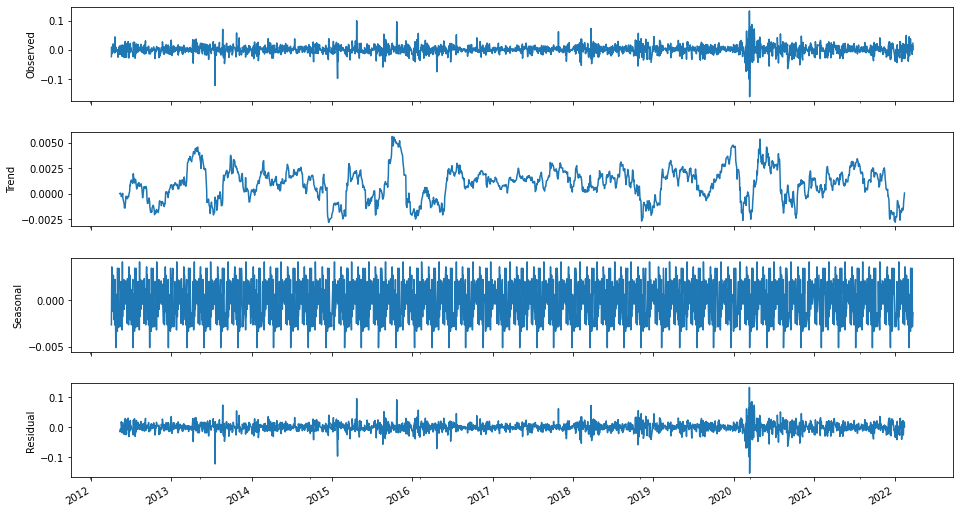

In [32]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Podemos observar que el trend es un poco a la baja o constante en los ultimos dias.

# Feature Selection

Usemos [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) para seleccionar las mejores variables.

In [33]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Visualizaciones
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
DJIA,66.229
SP500,65.612
MSFT_DT,53.071
IBM,37.106
MSFT_6DT,34.697
GOOGL,20.663
MSFT_12DT,13.036
MSFT_3DT,12.991
VIXCLS,5.292


# Modelos

## Separemos los datos de Manera Adecuada

Dividamos los Datos de Manera Educada!

Ordenemoslos por timestamp (que es le indice).

In [34]:
X = X.sort_index(ascending=True)
X.reset_index(drop=True, inplace=True)
Y = Y.sort_index(ascending=True)
Y.reset_index(drop=True, inplace=True)

In [35]:
n_test = 50

#Test
X_test = X[-n_test:]
Y_test = Y[-n_test:]
# Train
X_train = X[:-n_test]
Y_train = Y[:-n_test]


In [36]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
split_idx = []
for train_index, test_index in tscv.split(X_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    split_idx.append((train_index, test_index))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [37]:
split_idx

[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
         143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
         156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 171, 172, 173, 174,

Originalmente obtuve un warning de que sklearn dejaria de utilisar el `rmse` y pasaria a utilizar `neg_mean_squared_error`

In [38]:
seed = 7
scoring = 'neg_mean_squared_error'

## Modelos Clasicos

**Modelos Estandar**

In [39]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))
models.append(('DummyMean', DummyRegressor()))
models.append(('DummyMed', DummyRegressor(strategy='median')))


**Modelos de Boosting y Bagging**

In [40]:
# Boosting 
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging 
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

### K-folds para eleccion de modelos

In [41]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X=X_train, y=Y_train, cv=split_idx, 
                                     scoring=scoring, n_jobs=-1)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), 
                                 train_result, test_result)
    print(msg)

LR: 0.000267 (0.000117) 0.000248 0.000468
LASSO: 0.000270 (0.000126) 0.000262 0.000462
EN: 0.000270 (0.000126) 0.000262 0.000462
KNN: 0.000304 (0.000131) 0.000190 0.000463
CART: 0.000551 (0.000197) 0.000000 0.001085
SVR: 0.000549 (0.000193) 0.000457 0.000656
MLP: 0.000298 (0.000107) 0.000252 0.000487
DummyMean: 0.000270 (0.000126) 0.000262 0.000462
DummyMed: 0.000270 (0.000126) 0.000262 0.000462
ABR: 0.000305 (0.000126) 0.000243 0.000504
GBR: 0.000292 (0.000123) 0.000163 0.000482
RFR: 0.000283 (0.000128) 0.000037 0.000478
ETR: 0.000284 (0.000127) 0.000000 0.000465


In [42]:
_mod = Lasso()
_mod.fit(X_train, Y_train)
print(_mod.coef_)
print(_mod.intercept_)

[-0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0.]
0.0010171334168337055


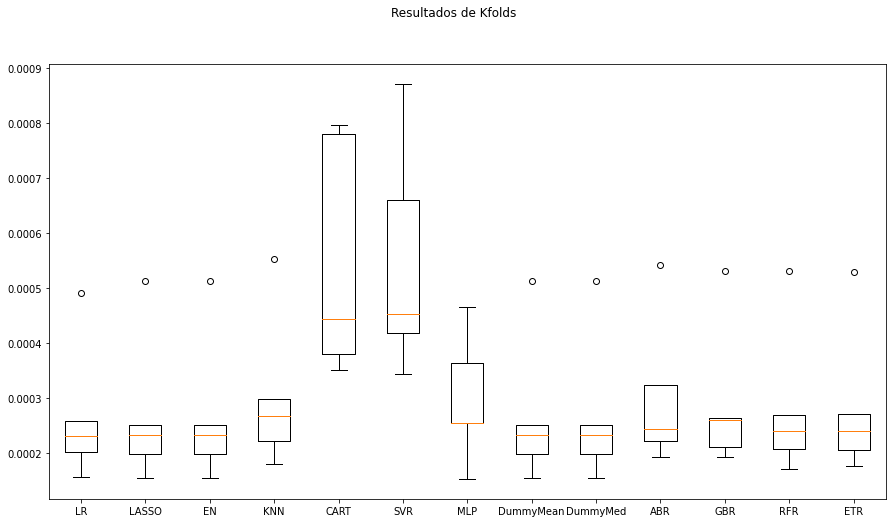

In [43]:
fig = pyplot.figure()
fig.suptitle('Resultados de Kfolds')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

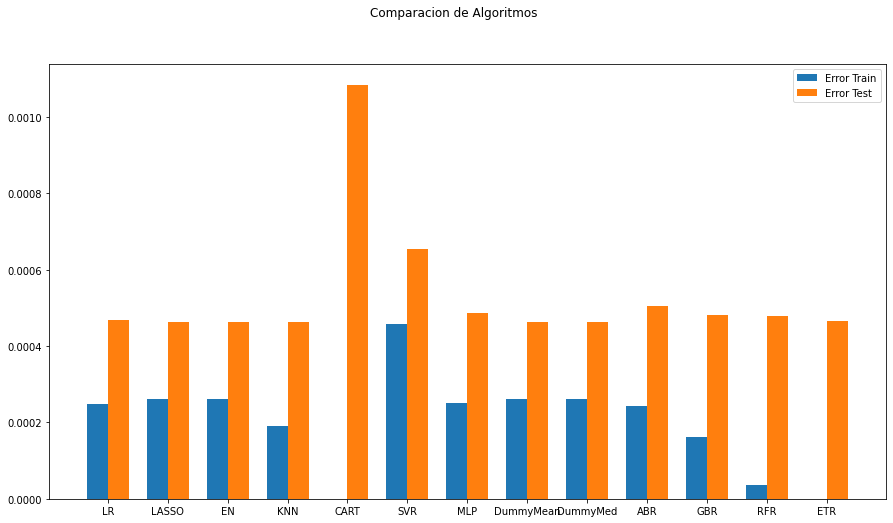

In [44]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparacion de Algoritmos')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Error Train')
pyplot.bar(ind + width/2, test_results, width=width, label='Error Test')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

+ Parece que los modelos CART y ETR tiene muy buen performance en el train, pero pesimo en el test.  
+ Los modelos de **ensamble** como GBR y RF tienen **bias pequeño**, pero **varianza alta**

## Modelos de time Series

Documentacion [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

Video explicacion de [ARIMA](https://www.youtube.com/watch?v=emF1iBcni0U)

In [45]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [46]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [47]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.00045799952185367074

## Deep Learning: LSTM

In [48]:
#Tamaño de Secuencia de LSTM
seq_len = 2 

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [49]:
# LSTM Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #Cells 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=330, batch_size=72, verbose=0, shuffle=False)

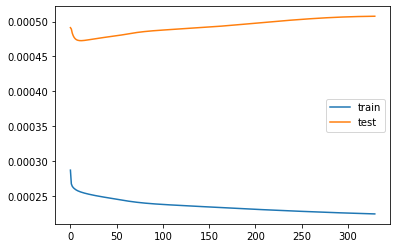

In [50]:
#Visualizacion del Error
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),
                              epochs=80, batch_size=72, verbose=0, shuffle=False)

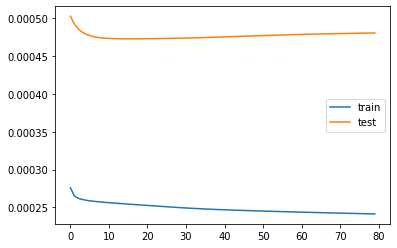

In [52]:
#Visualizacion del error
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [53]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [54]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Analisis de Resultados

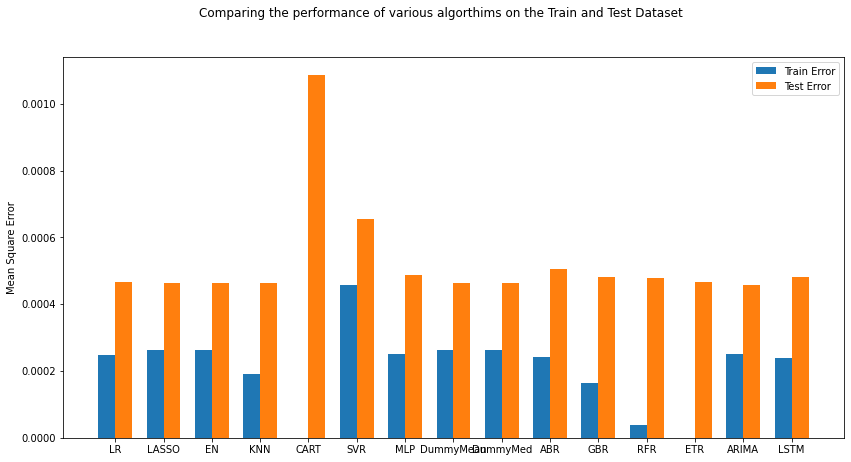

In [55]:
# Comparar Algoritmos
fig = pyplot.figure()

ind = np.arange(len(names))  
width = 0.35  

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(14,7)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Parece que los modelos **lineales**, **KNN**, **ARIMA** y **LSTM** tienen el mejor performance en el test y train.  
Para probar algo nuevo, utilizaremos el modelo ARIMA.

# Tuneo de ARIMA

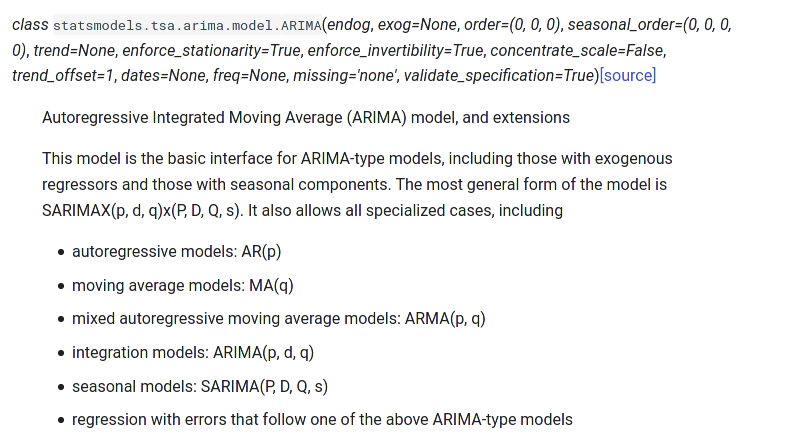

**Tarea**  
Determinar / estudiar / investigar, el significado del parametro `d` en el modelo `ARIMA`.

In [56]:
def evaluate_arima_model(arima_order):
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    tr_len = len(X_train_ARIMA)
    te_len = len(X_test_ARIMA)
    to_len = len (X)
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
    error_Test_ARIMA = mean_squared_error(Y_test,predicted)
    return error_Test_ARIMA
 
# Evaluar
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

In [57]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values) 

ARIMA(0, 0, 0) MSE=0.0004576
ARIMA(0, 0, 1) MSE=0.0004580
ARIMA(0, 0, 2) MSE=0.0004580
ARIMA(1, 0, 0) MSE=0.0004580
ARIMA(1, 0, 1) MSE=0.0004580
ARIMA(2, 0, 0) MSE=0.0004579
ARIMA(2, 0, 1) MSE=0.0004595
Best ARIMA(0, 0, 0) MSE=0.0004576


# Finalizacion de Arima

In [58]:
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [59]:
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.00045799952185367074


## Pickles para Guardar Modelos

[Pickle](https://docs.python.org/3/library/pickle.html)

In [60]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model_test.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [61]:
# open the file for reading
pickle_in = open("finalized_model_test.sav", "rb")
# load the object from the file into var a
a = load(pickle_in)

print(a)

In [62]:
predicted_tuned = a.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0004594502272635645


# Aprendizajes

Observa como no le ganamos a la media o mediana de los modelos Dummies de forma facil,  a pesar de utilizar diferentes modelos. Podriamos incluir:
+ Mas datos
+ Mas Variables: 
+ Otros modelos: Analisis de Sentimientos, Procesamiento del Lenguaje Natural
+ Otros Proyectos: Portafolios de Inversion, Bots